In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets

from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [142]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        feature = out  # 最後にチャネルを1つに集約する手前の情報
        feature = feature.view(feature.size()[0], -1)  # 2次元に変換

        out = self.last(out)

        return out, feature

G = Generator(z_dim=20, image_size=64)
D = Discriminator(z_dim=20, image_size=64)

In [143]:
# 画像の前処理
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 画像サイズを64x64に変更
    transforms.ToTensor()
])

batch_size = 64
device = 'cuda'
n_epochs = 15

# 指定されたラベルのみをフィルタリングする関数
def filter_by_labels(dataset, labels):
    indices = [i for i, (_, label) in enumerate(dataset) if label in labels]
    return Subset(dataset, indices)

# MNISTの訓練データと検証データをロード
train_dataset = datasets.MNIST('./data/MNIST', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)

# フィルタリングしたいラベル
train_labels = [6, 7, 8]
valid_labels = [6, 7, 8, 5]

# フィルタリング
train_dataset = filter_by_labels(train_dataset, train_labels)
valid_dataset = filter_by_labels(valid_dataset, valid_labels)

# DataLoaderの作成
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



In [144]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")

ネットワークの初期化完了


In [145]:
def train_model(G, D, dataloader, num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    g_lr, d_lr = 0.001, 0.001
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    criterion_real_fake = nn.BCEWithLogitsLoss(reduction='mean')
    criterion_class = nn.CrossEntropyLoss(reduction='mean')

    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    D.to(device)

    G.train()
    D.train()

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        for images, labels in dataloader:

            if images.size()[0] == 1:
                continue

            images = images.to(device)
            labels = labels.to(device)

            mini_batch_size = images.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            d_out_real, class_out_real = D(images)
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, class_out_fake = D(fake_images)

            d_loss_real = criterion_real_fake(d_out_real.view(-1), label_real.float())
            d_loss_fake = criterion_real_fake(d_out_fake.view(-1), label_fake.float())
            #d_loss_class_real = criterion_class(class_out_real, labels)
            #d_loss = d_loss_real + d_loss_fake + d_loss_class_real
            d_loss = d_loss_real + d_loss_fake
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, class_out_fake = D(fake_images)

            g_loss_real_fake = criterion_real_fake(d_out_fake.view(-1), label_real.float())
            g_loss = g_loss_real_fake

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("総イテレーション回数:", iteration)

    return G, D


In [146]:
# 学習・検証を実行する
num_epochs = 10
G_update, D_update = train_model(
    G, D, dataloader=dataloader_train, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 0/10
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:5.8623 ||Epoch_G_Loss:4.7173
timer:  8.6277 sec.
-------------
Epoch 1/10
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:5.8078 ||Epoch_G_Loss:4.3261
timer:  8.4826 sec.
-------------
Epoch 2/10
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:5.4040 ||Epoch_G_Loss:5.5108
timer:  8.1991 sec.
-------------
Epoch 3/10
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:4.8260 ||Epoch_G_Loss:7.5030
timer:  8.1070 sec.
-------------
Epoch 4/10
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:4.4302 ||Epoch_G_Loss:8.7919
timer:  8.9842 sec.
-------------
Epoch 5/10
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:4.1580 ||Epoch_G_Loss:9.8996
timer:  9.4225 sec.
-------------
Epoch 6/10
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:4.1447 ||Epoch_G_Loss:10.2898
timer:  8.9852 sec.
-------------
Epoch 7/10
-------------
（train）

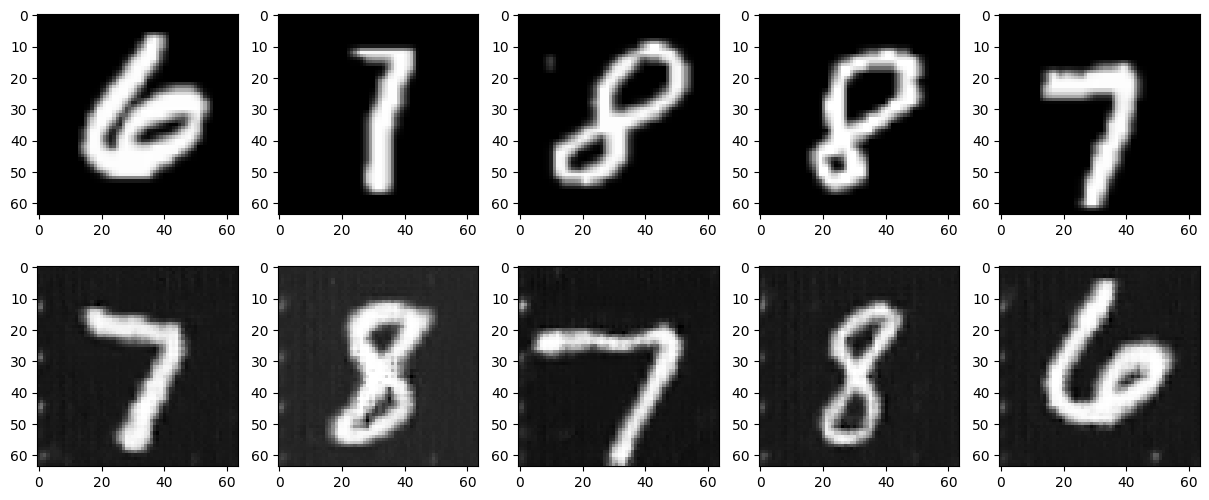

In [147]:
# 生成画像と訓練データを可視化する
# 本セルは何度か実行し直しています。

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(dataloader_train)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[0][i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

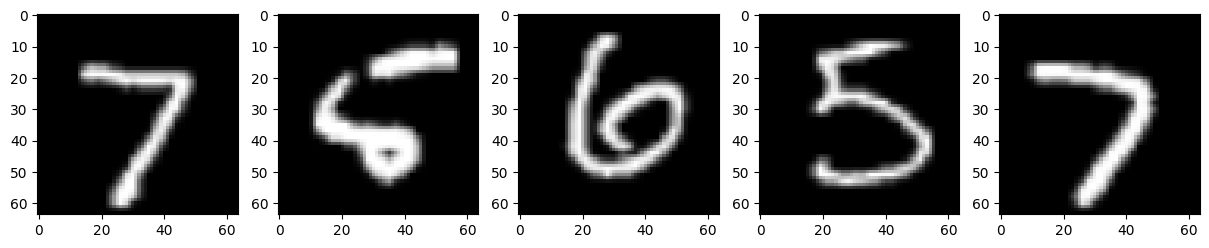

In [148]:
# テストデータの確認
batch_iterator = iter(dataloader_valid)  # イテレータに変換
imges = next(batch_iterator)  

# 1番目のミニバッチを取り出す

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[0][i][0].cpu().detach().numpy(), 'gray')

In [149]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):

    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量を取り出す
    _, x_feature = D(x)
    _, G_feature = D(fake_img)

    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    
    # #298より不要なコードなのでコメントアウト
    # discrimination_loss = discrimination_loss.view(
    #    discrimination_loss.size()[0], -1)
    
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss


In [150]:
# 異常検知したい画像
x = imges[0][0:10]
x = x.to(device)

# 異常検知したい画像を生成するための、初期乱数
z = torch.randn(10, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

# 変数zを微分を求めることが可能なように、requires_gradをTrueに設定
z.requires_grad = True

# 変数zを更新できるように、zの最適化関数を求める
z_optimizer = torch.optim.Adam([z], lr=1e-3)


# zを求める
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))

epoch 0 || loss_total:6727 
epoch 1000 || loss_total:3209 
epoch 2000 || loss_total:2452 
epoch 3000 || loss_total:1910 
epoch 4000 || loss_total:1743 
epoch 5000 || loss_total:1692 


total loss： [ 82. 439. 162. 303.  86. 107. 163. 174.  73. 104.]


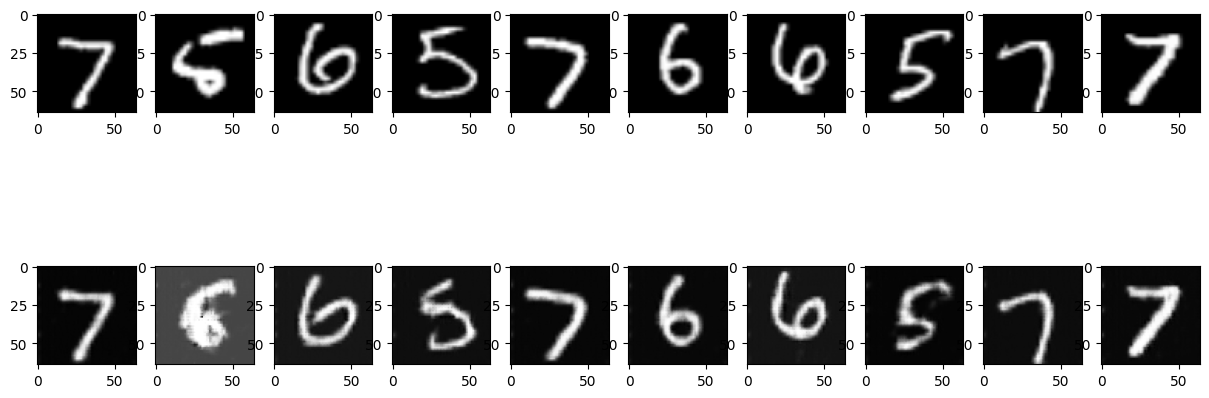

In [151]:
# 画像を生成
G_update.eval()
fake_img = G_update(z)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    x, fake_img, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 10):
    # 上段にテストデータを
    plt.subplot(2, 10, i+1)
    plt.imshow(imges[0][i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 10, 10+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')

In [152]:
# 異常検知したい画像
x = imges[0][0:50]
x = x.to(device)

# 異常検知したい画像を生成するための、初期乱数
z = torch.randn(50, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

# 変数zを微分を求めることが可能なように、requires_gradをTrueに設定
z.requires_grad = True

# 変数zを更新できるように、zの最適化関数を求める
z_optimizer = torch.optim.Adam([z], lr=1e-3)


# zを求める
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))

epoch 0 || loss_total:28210 
epoch 1000 || loss_total:16016 
epoch 2000 || loss_total:10616 
epoch 3000 || loss_total:8898 
epoch 4000 || loss_total:8280 
epoch 5000 || loss_total:7858 


total loss： [ 78. 512. 161. 336.  85. 101. 203. 164.  73. 100. 163. 120. 171.  89.
 234. 170. 234. 188. 146. 181. 205. 186. 129. 106.  94.  81.  98.  76.
 151.  89. 129.  93. 173. 119. 166. 257. 102.  69. 150. 250.  58. 118.
 207. 250. 158. 219. 126. 110. 216. 160.]


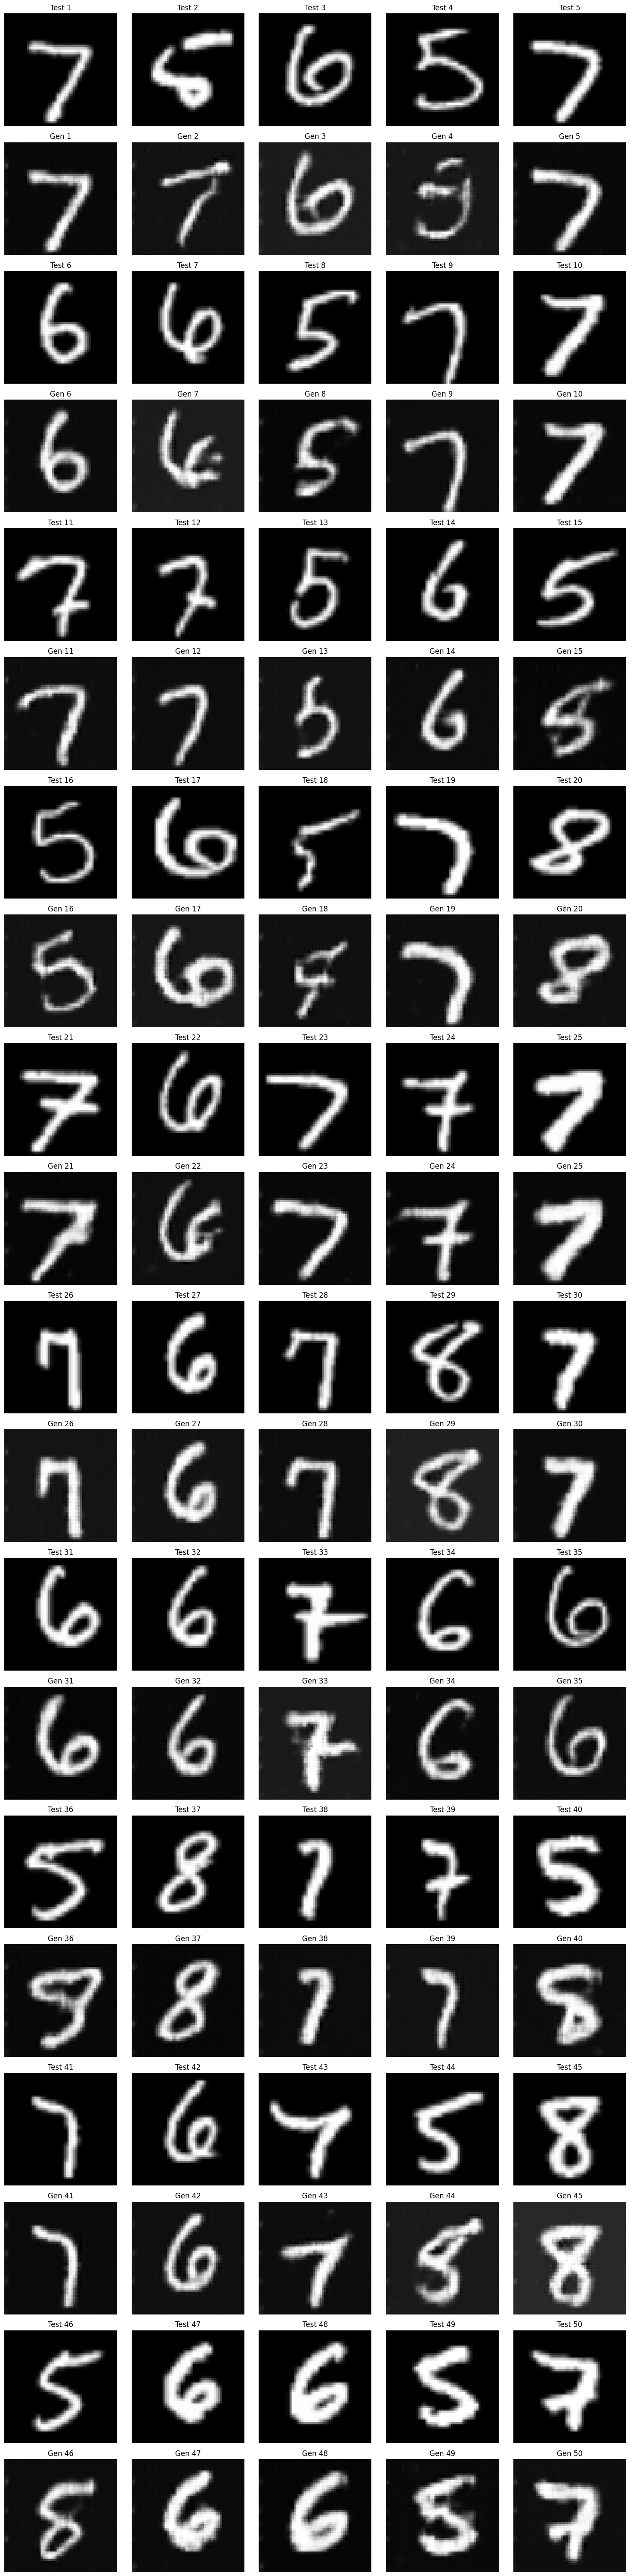

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# 画像を生成
G_update.eval()
fake_img = G_update(z)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    x, fake_img, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 画像を可視化
fig, axes = plt.subplots(20, 5, figsize=(15, 60))  # 20行5列のサブプロット

for i in range(50):  # 50枚の画像を表示
    # 行と列のインデックスを計算
    row = (i // 5) * 2
    col = i % 5

    # 上段にテストデータを表示
    ax = axes[row, col]
    ax.imshow(imges[0][i][0].cpu().detach().numpy(), cmap='gray')
    ax.set_title(f'Test {i + 1}' if row % 2 == 0 else '')
    ax.axis('off')

    # 下段に生成データを表示
    ax = axes[row + 1, col]
    ax.imshow(fake_img[i][0].cpu().detach().numpy(), cmap='gray')
    ax.set_title(f'Gen {i + 1}' if row % 2 == 0 else '')
    ax.axis('off')


plt.tight_layout()
plt.show()


In [175]:
import numpy as np
import torch

# 閾値を設定
threshold = 200

# ラベルに基づく異常/正常の判定
def get_labels_for_anomalies(labels):
    return np.array([1 if label == 5 else 0 for label in labels])

# 損失値に基づく異常検知
def get_anomaly_predictions(losses, threshold):
    return np.array([1 if loss > threshold else 0 for loss in losses])

# 損失値
loss_each = np.round(loss_each, 0)

# ラベル
true_labels = np.array(imges[1][0:50])

# 正しいラベルに基づく異常/正常の判定
true_labels_for_anomalies = get_labels_for_anomalies(true_labels)

# 損失値に基づく異常検知の結果
anomalies_detected = get_anomaly_predictions(loss_each, threshold)

# 正解率の計算
accuracy = np.mean(anomalies_detected == true_labels_for_anomalies)

print(f'Anomaly Scores: {loss_each}')
print(f'Anomalies Detected: {anomalies_detected}')
print(f'True Labels: {true_labels_for_anomalies}')
print(f'Accuracy: {accuracy * 100:.2f}%')

Anomaly Scores: [ 78. 512. 161. 336.  85. 101. 203. 164.  73. 100. 163. 120. 171.  89.
 234. 170. 234. 188. 146. 181. 205. 186. 129. 106.  94.  81.  98.  76.
 151.  89. 129.  93. 173. 119. 166. 257. 102.  69. 150. 250.  58. 118.
 207. 250. 158. 219. 126. 110. 216. 160.]
Anomalies Detected: [0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 1 1 0 1 0 0 1 0]
True Labels: [0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 1 0 1 0 0 1 0]
Accuracy: 84.00%
